In [577]:
import requests
import json
import pandas as pd
import string
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from collections import Counter

In [598]:
first,last = p.split(' ')[0],p.split(' ')[1]
url = f'https://www.capfriendly.com/players/{first}-{last}'
response = requests.get(url)
tables = pd.read_html(response.text)

In [600]:
len(tables)

2

In [602]:
dict_player = {}
df_allContracts = pd.DataFrame()
for t in (tables[:-1]):
    t_new = t.iloc[1:,[0,2]]
    contract_length = t_new.shape[0]-1
    start_year = (int(t_new.iloc[0,0].split('-')[0]) if isinstance(t_new.iloc[0,0].split('-')[0],str) else None)
    total_value = (int(t_new.iloc[-1,1].replace('$','').replace(',','')) if isinstance(t_new.iloc[-1,1],str) else None)
    df_allContracts.loc[start_year,'Value'] = total_value
    df_allContracts.loc[start_year,'Length'] = contract_length

In [606]:
df_allContracts.shape

(0, 2)

In [609]:
def getPlayerContractData(df_players,cap_table):
    "Returns a dictionary with key corresponding to player and value corresponding to dictionary of two tables:"
    "The first table is contract specific data and player-immutable data, and the second table is more detailed statistics"
    dict_contracts = {}
    
    for p in list(df_players.index):
        print(p)
        first,last = p.split(' ')[0],p.split(' ')[1]
        url = f'https://www.capfriendly.com/players/{first}-{last}'
        response = requests.get(url)
        try:
            tables = pd.read_html(response.text)
        except ValueError:
            continue
        
        if len(tables) < 2:
            continue
        dict_player = {}
        df_allContracts = pd.DataFrame()
        for t in (tables[:-1]):
            t_new = t.iloc[1:,[0,2]]
            contract_length = t_new.shape[0]-1
            start_year = (int(t_new.iloc[0,0].split('-')[0]) if isinstance(t_new.iloc[0,0].split('-')[0],str) else None)
            total_value = (int(t_new.iloc[-1,1].replace('$','').replace(',','')) if isinstance(t_new.iloc[-1,1],str) else None)
            df_allContracts.loc[start_year,'Value'] = total_value
            df_allContracts.loc[start_year,'Length'] = contract_length

        df_allContracts = df_allContracts.dropna(axis=0)
        if (df_allContracts.shape[0] < 1):
            continue
        df_allContracts['AAV'] = (df_allContracts['Value']/df_allContracts['Length'])
        for y in list(df_allContracts.index):
            df_allContracts.loc[y,'Contract Age'] = y-df_players.loc[p,'birthYear']
            if y >= 2005:
                df_allContracts.loc[y,'Cap Hit'] = df_allContracts.loc[y,'AAV']/cap_table.loc[y,'UPPER LIMIT']
            else:
                df_allContracts.loc[y,'Cap Hit'] = 0
        df_allContracts = df_allContracts[df_allContracts['Cap Hit'] > 0]
        
        df_allContracts['Position'] = df_players.loc[p,'Position']
        df_allContracts['Nationality'] = df_players.loc[p,'nationality']
        df_allContracts['Height'] = df_players.loc[p,'height']
        df_allContracts['Overall Pick'] = df_players.loc[p,'Overall Pick']
        
        summary_table = tables[-1]
        summary_table = summary_table[~summary_table['SEASON'].isna()].iloc[:-1,:]
        summary_table = summary_table[summary_table['LEAGUE'] == 'NHL']
        summary_table['SEASON ENDING'] = summary_table['SEASON'].apply(lambda x: int(x.split('-')[0][:2]+x.split('-')[1]))
        summary_table = summary_table.set_index('SEASON ENDING')

        dict_player['Summary'] = df_allContracts
        dict_player['Stats'] = summary_table
        dict_contracts[p] = dict_player
        
    return dict_contracts

In [3]:
def getDataTable_g(dict_players):
    
    df_final = pd.DataFrame()
    
    for p in list(dict_players.keys()):
        
        df_stat_summary = dict_players[p]['Stats'].drop(columns=['SEASON','TEAM','LEAGUE','Unnamed: 3','Unnamed: 7','Unnamed: 15','PLAYOFFS.1','PLAYOFFS'])
        df_stat_summary.columns = ['GAMES_PLAYED','GAA','Sv%','GP_PLAYOFF','GAA_PLAYOFF','Sv%_PLAYOFF','GA60','xGA60','GSAx60','GA60_PLAYOFF',
                                   'xGA60_PLAYOFF','GSAx60_PLAYOFF']
        df_stat_summary = df_stat_summary.fillna(0)
        df_stat_summary = df_stat_summary.applymap(lambda x: pd.to_numeric(x) if x != '-' else 0)

        df_contract_allData = dict_players[p]['Summary'].copy()

        df_data = pd.DataFrame()

        for y in list(dict_players[p]['Summary'].index):
            ct_years = [y,y-1,y-2]
            ct_year_symbols = ['_t','_t1','_t2']
            ls_temp = []
            t_count = 0
            for t in ct_years:
                if t in df_stat_summary.index:
                    row_t = df_stat_summary.loc[t]
                    row_t.index = [c + ct_year_symbols[ct_years.index(t)] for c in row_t.index]
                    df_temp = pd.DataFrame(row_t).T
                    df_temp.index = [y]
                    ls_temp.append(df_temp)
                    t_count += 1
                else:
                    df_temp = pd.DataFrame(0,columns = [c + ct_year_symbols[ct_years.index(t)] for c in df_stat_summary.columns],index=[y])
                    ls_temp.append(df_temp)

            if t_count > 0:
                avg = (np.array(ls_temp[0].values)+np.array(ls_temp[1].values)+(ls_temp[2].values))/t_count
                avg_columns = [c + '_avg' for c in df_stat_summary.columns]
                avg_df = pd.DataFrame(avg,columns=avg_columns,index=[y])
                df_y = pd.concat([ls_temp[0],ls_temp[1],ls_temp[2],avg_df],axis=1)

                if df_data.empty:
                    df_data = df_y
                else:
                    df_data = pd.concat([df_data,df_y],axis=0)

            else:
                df_contract_allData = df_contract_allData.drop(labels=[y],axis=0)

        df_final_player = df_contract_allData.merge(df_data,left_index=True,right_index=True)
        
        if df_final.empty:
            df_final = df_final_player
        else:
            df_final = pd.concat([df_final,df_final_player],axis=0)
    
    return df_final

In [50]:
def getDataTable_ng(dict_contracts):
    
    df_final = pd.DataFrame()
    
    for p in list(dict_contracts.keys()):
        df_stat_summary = dict_contracts[p]['Stats'].drop(columns=['SEASON','TEAM','LEAGUE','Unnamed: 3','Unnamed: 10','Unnamed: 25','Unnamed: 33','PLAYOFFS',
                                                                    'G.3','G.2'])
        df_stat_summary.columns = ['GAMES_PLAYED','G','A','P','PLUS_MINUS','PIM','GP_PLAYOFF','G_PLAYOFF','A_PLAYOFF','P_PLAYOFF','PLUS_MINUS_PLAYOFF',
                                   'PIM_PLAYOFF','TOI','ixG','xG±/60','RelxG±/60', 'C±/60', 'RelC±/60','TOI_PLAYOFF','ixG_PLAYOFF','xG±/60_PLAYOFF',
                                   'RelxG±/60_PLAYOFF','C±/60_PLAYOFF','RelC±/60_PLAYOFF']
        df_stat_summary = df_stat_summary.fillna(0)
        df_stat_summary['TOI'] = df_stat_summary['TOI'].apply(lambda x: (x.split(':')))
        df_stat_summary['TOI'] = df_stat_summary['TOI'].apply(lambda x: int(x[0])+(pd.to_numeric(x[1])/60) if len(x) > 1 else 0)
        df_stat_summary['TOI_PLAYOFF'] = df_stat_summary['TOI_PLAYOFF'].apply(lambda x: (x.split(':')))
        df_stat_summary['TOI_PLAYOFF'] = df_stat_summary['TOI_PLAYOFF'].apply(lambda x: int(x[0])+(pd.to_numeric(x[1])/60) if len(x) > 1 else 0)
        df_stat_summary = df_stat_summary.applymap(lambda x: pd.to_numeric(x) if x != '-' else 0)

        df_stat_summary['G_PG'] = df_stat_summary.apply(lambda row: (row.G/row.GAMES_PLAYED if row.GAMES_PLAYED > 0 else 0),axis=1)
        df_stat_summary['P_PG'] = df_stat_summary.apply(lambda row: (row.P/row.GAMES_PLAYED if row.GAMES_PLAYED > 0 else 0),axis=1)
        df_stat_summary['PIM_PG'] = df_stat_summary.apply(lambda row: (row.PIM/row.GAMES_PLAYED if row.GAMES_PLAYED > 0 else 0),axis=1)

        df_stat_summary['G_PG_PLAYOFF'] = df_stat_summary.apply(lambda row: (row.G_PLAYOFF/row.GP_PLAYOFF if row.GP_PLAYOFF > 0 else 0),axis=1)
        df_stat_summary['P_PG_PLAYOFF'] = df_stat_summary.apply(lambda row: (row.P_PLAYOFF/row.GP_PLAYOFF if row.GP_PLAYOFF > 0 else 0),axis=1)
        df_stat_summary = df_stat_summary.applymap(lambda x: pd.to_numeric(x) if x != '-' else 0)
        
        df_contract_allData = dict_contracts[p]['Summary'].copy()

        df_data = pd.DataFrame()

        for y in list(dict_contracts[p]['Summary'].index):
            ct_years = [y,y-1,y-2]
            ct_year_symbols = ['_t','_t1','_t2']
            ls_temp = []
            t_count = 0
            for t in ct_years:
                if t in df_stat_summary.index:
                    row_t = df_stat_summary.loc[t]
                    row_t.index = [c + ct_year_symbols[ct_years.index(t)] for c in row_t.index]
                    df_temp = pd.DataFrame(row_t).T
                    df_temp.index = [y]
                    ls_temp.append(df_temp)
                    t_count += 1
                else:
                    df_temp = pd.DataFrame(0,columns = [c + ct_year_symbols[ct_years.index(t)] for c in df_stat_summary.columns],index=[y])
                    ls_temp.append(df_temp)

            if t_count > 0:
                avg = (np.array(ls_temp[0].values)+np.array(ls_temp[1].values)+(ls_temp[2].values))/t_count
                avg_columns = [c + '_avg' for c in df_stat_summary.columns]
                avg_df = pd.DataFrame(avg,columns=avg_columns,index=[y])
                df_y = pd.concat([ls_temp[0],ls_temp[1],ls_temp[2],avg_df],axis=1)

                if df_data.empty:
                    df_data = df_y
                else:
                    df_data = pd.concat([df_data,df_y],axis=0)

            else:
                df_contract_allData = df_contract_allData.drop(labels=[y],axis=0)

        df_final_player = df_contract_allData.merge(df_data,left_index=True,right_index=True)
        
        if df_final.empty:
            df_final = df_final_player
        else:
            df_final = pd.concat([df_final,df_final_player],axis=0)
    
    return df_final

For the first step of obtaining data, we need to get a list of players for whome we will capture contract data. To do this, we will look at active NHL players since 2006, limited to the realm of current teams.

In [299]:
requests_teams = requests.get('https://statsapi.web.nhl.com/api/v1/teams')

In [300]:
teams = json.loads(test.text)['teams']

In [301]:
len(teams)

32

In [8]:
teams[0]

{'id': 1,
 'name': 'New Jersey Devils',
 'link': '/api/v1/teams/1',
 'venue': {'name': 'Prudential Center',
  'link': '/api/v1/venues/null',
  'city': 'Newark',
  'timeZone': {'id': 'America/New_York', 'offset': -4, 'tz': 'EDT'}},
 'abbreviation': 'NJD',
 'teamName': 'Devils',
 'locationName': 'New Jersey',
 'firstYearOfPlay': '1982',
 'division': {'id': 18,
  'name': 'Metropolitan',
  'nameShort': 'Metro',
  'link': '/api/v1/divisions/18',
  'abbreviation': 'M'},
 'conference': {'id': 6, 'name': 'Eastern', 'link': '/api/v1/conferences/6'},
 'franchise': {'franchiseId': 23,
  'teamName': 'Devils',
  'link': '/api/v1/franchises/23'},
 'shortName': 'New Jersey',
 'officialSiteUrl': 'http://www.newjerseydevils.com/',
 'franchiseId': 23,
 'active': True}

In [9]:
team_ids = {t['name']:t['id'] for t in teams}

In [310]:
team_ids

{'New Jersey Devils': 1,
 'New York Islanders': 2,
 'New York Rangers': 3,
 'Philadelphia Flyers': 4,
 'Pittsburgh Penguins': 5,
 'Boston Bruins': 6,
 'Buffalo Sabres': 7,
 'Montréal Canadiens': 8,
 'Ottawa Senators': 9,
 'Toronto Maple Leafs': 10,
 'Carolina Hurricanes': 12,
 'Florida Panthers': 13,
 'Tampa Bay Lightning': 14,
 'Washington Capitals': 15,
 'Chicago Blackhawks': 16,
 'Detroit Red Wings': 17,
 'Nashville Predators': 18,
 'St. Louis Blues': 19,
 'Calgary Flames': 20,
 'Colorado Avalanche': 21,
 'Edmonton Oilers': 22,
 'Vancouver Canucks': 23,
 'Anaheim Ducks': 24,
 'Dallas Stars': 25,
 'Los Angeles Kings': 26,
 'San Jose Sharks': 28,
 'Columbus Blue Jackets': 29,
 'Minnesota Wild': 30,
 'Winnipeg Jets': 52,
 'Arizona Coyotes': 53,
 'Vegas Golden Knights': 54,
 'Seattle Kraken': 55}

In [349]:
# get roster for each team
dict_teamRosters = {}

for team in list(team_ids.keys()):
    team_id = team_ids[team]
    season = 2006
    list_rosters = []
    while (season < 2022):
        season_string = f'{season}{season+1}'
        request_roster_season = requests.get(f'https://statsapi.web.nhl.com/api/v1/teams/{team_id}/roster?expand=team.roster&season={season_string}')
        roster = json.loads(request_roster_season.text)
        df_roster = pd.DataFrame()
        try:
            for r in roster['roster']:
                player_id = r['person']['id']
                df_roster.loc[player_id,'Name'] = r['person']['fullName']
                df_roster.loc[player_id,'Position'] = r['position']['code']
            list_rosters.append(df_roster)
            season += 1
        except KeyError:
            season += 1
    df_team = pd.concat(list_rosters,axis=0)
    df_team = df_team.drop_duplicates()
    dict_teamRosters[team] = df_team

Now that we have a list of players for each of the current teams since 2006, we can go through each of the dataframes and append relevant informationa about each player. This dataframe will be the basis for the collection of immutable player data, or the data that will be consistently applied to each player over time. It will be combined with player statistics that are mutable on a yearly basis to form the dataset that will be modeled. 

In [355]:
for df_team in list(dict_teamRosters.values()):
    for i in list(df_team.index):
        player_request = requests.get(f'https://statsapi.web.nhl.com/api/v1/people/{i}')
        player = json.loads(player_request.text)['people'][0]
        df_team.loc[i,'birthDate'] = player['birthDate']
        df_team.loc[i,'nationality'] = player['nationality']
        height_list = [int(player['height'].split(' ')[i].translate(str.maketrans('','',string.punctuation))) for i in [0,1]]
        df_team.loc[i,'height'] = height_list[0]*12+height_list[1]
        #df_team.loc[i,'weight'] = player['weight']

With the organization of the NHL API by team, we can use the dataframes constructed for each team's roster to create one large 'player information' dataframe, which we can continue to populate with information about the player that is considered 'timeless,' or data that does not vary by season. While it is possible that a player's weight fluctuates over the course of their career (and in fact probably does), we will make the assumption that height does not. Moreover, we will assume that a player continues in the same position for the course of their career.

For the last step of this part of the data processing, we will combine all of the player information to a final dataframe that will be used to query contract details and more advanced statistics. We will also have to deal with missing values.

In [564]:
df_players = pd.DataFrame()
for df_team in list(dict_teamRosters.values()):
    if df_players.empty:
        df_players = df_team
    else:
        df_players = pd.concat([df_players,df_team],axis=0)
df_players.index.name = 'Player ID'

In [565]:
df_players.head()

,Name,Position,birthDate,nationality,height
Player ID,,,,,
8456100,Jim Dowd,C,1968-12-25,USA,72.0
8458522,Richard Matvichuk,D,1973-02-05,CAN,75.0
8458978,Sergei Brylin,L,1974-01-13,RUS,70.0
8459454,Jay Pandolfo,L,1974-12-27,USA,73.0
8459457,Jamie Langenbrunner,R,1975-07-24,USA,73.0


In [566]:
df_players.shape

(6802, 5)

In [567]:
df_players.isna().sum()

Name           0
Position       0
birthDate      0
nationality    0
height         0
dtype: int64

In [568]:
df_players = df_players.drop_duplicates(subset=['Name','birthDate'])

In [569]:
df_players.shape

(3167, 5)

In [576]:
df_players.duplicated(subset='Name')

Player ID
8456100    False
8458522    False
8458978    False
8459454    False
8459457    False
           ...  
8481527    False
8481604    False
8481849    False
8482624    False
8482665    False
Length: 3167, dtype: bool

In [581]:
bad_names = [name for name, count in Counter(df_players['Name']).items() if count != 1]

In [582]:
df_players = df_players[~df_players['Name'].isin(bad_names)]

In [583]:
df_players.shape

(3150, 5)

In [532]:
# get draft data
start_year = 1990
current_year = 2023

df_draft = pd.DataFrame()

while (start_year < current_year):
    draft_req = requests.get(f'https://statsapi.web.nhl.com/api/v1/draft/{start_year}')
    draft = json.loads(draft_req.text)['drafts'][0]
    for r in (draft['rounds']):
        for p in (r['picks']):
            player = p['prospect']['fullName']
            pick_overall = p['pickOverall']
            df_draft.loc[player,'Overall Pick'] = pick_overall
            df_draft.loc[player,'Year'] = start_year
    start_year += 1

In [553]:
df_draft.head()

,Overall Pick,Year
Mika Stromberg,211.0,1990.0
Tyler Ertel,212.0,1990.0
Brett Larson,213.0,1990.0
Tommy Soderstrom,214.0,1990.0
Michael Thompson,215.0,1990.0


In [554]:
df_draft.shape

(7804, 2)

In [555]:
df_draft.isna().sum()

Overall Pick    0
Year            0
dtype: int64

A player's draft record is also something that does not change over the course of the career - in fact it only happens once - so we will also populate the players dataframe with that information. For the rare case of undrafted players, there is some question of how they should be treated - without knowing if this is even a significant predictor, we will treat the missing values by filling with the median draft pick.

In [584]:
df_players = df_players.reset_index().set_index('Name')

In [585]:
df_players.head()

,Player ID,Position,birthDate,nationality,height
Name,,,,,
Jim Dowd,8456100,C,1968-12-25,USA,72.0
Richard Matvichuk,8458522,D,1973-02-05,CAN,75.0
Sergei Brylin,8458978,L,1974-01-13,RUS,70.0
Jay Pandolfo,8459454,L,1974-12-27,USA,73.0
Jamie Langenbrunner,8459457,R,1975-07-24,USA,73.0


In [587]:
df_draft_lower = df_draft.copy()
df_draft_lower.index = pd.Series(df_draft.index).apply(lambda x: x.lower())

for p in list(df_players.index):
    p_lower = p.lower()
    if p_lower in df_draft_lower.index:
        df_players.loc[p,'Overall Pick'] = df_draft_lower.loc[p_lower,'Overall Pick']
    else:
        df_players.loc[p,'Overall Pick'] = df_draft_lower['Overall Pick'].median()

In [588]:
df_players.head()

,Player ID,Position,birthDate,nationality,height,Overall Pick
Name,,,,,,
Jim Dowd,8456100,C,1968-12-25,USA,72.0,121.0
Richard Matvichuk,8458522,D,1973-02-05,CAN,75.0,8.0
Sergei Brylin,8458978,L,1974-01-13,RUS,70.0,42.0
Jay Pandolfo,8459454,L,1974-12-27,USA,73.0,32.0
Jamie Langenbrunner,8459457,R,1975-07-24,USA,73.0,35.0


In [589]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3150 entries, Jim Dowd to Matty Beniers
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player ID     3150 non-null   int64  
 1   Position      3150 non-null   object 
 2   birthDate     3150 non-null   object 
 3   nationality   3150 non-null   object 
 4   height        3150 non-null   float64
 5   Overall Pick  3150 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 236.8+ KB


In [590]:
df_players['birthYear'] = df_players['birthDate'].apply(lambda x: pd.to_numeric(x.split('-')[0]))

In [591]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3150 entries, Jim Dowd to Matty Beniers
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player ID     3150 non-null   int64  
 1   Position      3150 non-null   object 
 2   birthDate     3150 non-null   object 
 3   nationality   3150 non-null   object 
 4   height        3150 non-null   float64
 5   Overall Pick  3150 non-null   float64
 6   birthYear     3150 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 261.4+ KB


In [384]:
df_players.to_csv('api_players_data.csv')

In [388]:
df_players_id = df_players.reset_index().set_index('index')

In [412]:
# get stats for each player
player_stats = {}

for p in list(df_players_id.index):
    season = 2003
    dict_player = {}
    while(season < 2023):
        season_string = f'{season}{season+1}'
        player_request = requests.get(f'https://statsapi.web.nhl.com/api/v1/people/{player_id}/stats?stats=statsSingleSeason&season={season}')
        stats = json.loads(player_request.text)
        if not (stats['stats'][0]['splits']):
            continue
        else:
            dict_player[season] = stats['stats'][0]['splits'][0]['stat']
            start_season += 1
    player_stats[player_id] = dict_player

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
def getTableFromPlayerStats(dict_playerStats):
    
    for p in list(player_stats.keys()):
        df_player = pd.DataFrame()
        for s in list(player_stats[s].keys()):
            df_player = pd.DataFrame.from_dict(player_stats[8476467]).T
    

In [289]:
for p in list(player_stats.keys()):
    df_player = pd.DataFrame()
    for s in list(player_stats[s].keys()):

SyntaxError: incomplete input (1382348664.py, line 3)

In [290]:
df_player = pd.DataFrame.from_dict(player_stats[8476467]).T

In [291]:
df_player.index = pd.Series(df_player.index).apply(lambda x: x[4:])

In [292]:
df_player = df_player.drop(columns=['assists','penaltyMinutes','timeOnIce','evenTimeOnIce','powerPlayTimeOnIce','shortHandedTimeOnIce','shifts'])
df_player.columns = ['GOALS','PIM','SHOTS','GAMES_PLAYED','HITS','PP_G','PP_P','FACEOFF_PCT','SHOT_PCT','GW_GOALS','OT_GOALS',
                     'SH_GOALS','SH_P','BLOCKED','PM','POINTS','TOI','ES_TOI','SH_TOI','PP_TOI']

In [293]:
sub_c = ['GOALS','PIM','SHOTS','HITS','PP_G','PP_P','SH_GOALS','SH_P','BLOCKED','POINTS']
new_labels = [x+'_PG' for x in sub_c]
df_player[new_labels] = df_player[sub_c].div(df_player['GAMES_PLAYED'],axis=0)
df_player = df_player.drop(columns=sub_c,axis=1)

In [294]:
def convert_toi(toi_column):
    temp = toi_column.apply(lambda x: x.split(':'))
    column = temp.apply(lambda x: int(x[0])+pd.to_numeric(x[1])/60 if len(x) > 1 else 0)
    return column

In [295]:
toi_columns = ['TOI','ES_TOI','SH_TOI','PP_TOI']
for c in toi_columns:
    df_player[c] = convert_toi(df_player[c])

In [296]:
df_player = df_player.applymap(lambda x: pd.to_numeric(x))

In [297]:
df_player

,GAMES_PLAYED,FACEOFF_PCT,SHOT_PCT,GW_GOALS,OT_GOALS,PM,TOI,ES_TOI,SH_TOI,PP_TOI,GOALS_PG,PIM_PG,SHOTS_PG,HITS_PG,PP_G_PG,PP_P_PG,SH_GOALS_PG,SH_P_PG,BLOCKED_PG,POINTS_PG
2023,75,0.0,11.80,2,0,13,19.250000,16.316667,2.850000,0.050000,0.120000,0.960000,1.013333,1.680000,0.000000,0.000000,0.0,0.000000,1.533333,0.333333
2022,72,0.0,1.10,0,0,-1,19.316667,17.466667,1.766667,0.066667,0.013889,0.750000,1.319444,2.527778,0.000000,0.000000,0.0,0.013889,1.194444,0.236111
2021,56,0.0,7.10,2,0,-3,20.466667,18.850000,1.500000,0.116667,0.107143,0.625000,1.500000,2.642857,0.000000,0.000000,0.0,0.000000,1.571429,0.250000
2020,69,0.0,3.90,1,0,-6,15.800000,15.233333,0.533333,0.016667,0.043478,0.594203,1.101449,2.217391,0.000000,0.000000,0.0,0.000000,0.855072,0.144928
2019,57,0.0,7.27,0,0,5,14.716667,14.266667,0.366667,0.066667,0.070175,0.789474,0.964912,2.368421,0.000000,0.000000,0.0,0.000000,1.035088,0.210526
2018,68,0.0,6.17,1,0,7,16.650000,14.500000,1.866667,0.250000,0.073529,1.279412,1.191176,2.558824,0.014706,0.014706,0.0,0.000000,1.117647,0.250000
2017,41,0.0,15.15,1,0,-4,16.200000,14.850000,1.216667,0.116667,0.121951,0.902439,0.804878,1.243902,0.000000,0.000000,0.0,0.024390,1.292683,0.170732
2016,19,0.0,0.00,0,0,-5,12.700000,12.083333,0.600000,0.000000,0.000000,1.105263,0.684211,2.842105,0.000000,0.000000,0.0,0.000000,1.526316,0.105263
2015,36,0.0,2.78,0,0,0,13.383333,12.266667,1.066667,0.050000,0.027778,0.222222,1.000000,2.277778,0.000000,0.000000,0.0,0.000000,1.277778,0.222222
2014,7,0.0,0.00,0,0,-3,17.783333,14.350000,2.500000,0.916667,0.000000,0.285714,0.714286,2.285714,0.000000,0.000000,0.0,0.000000,2.000000,0.000000


In [414]:
# get salary cap data
url_cap = 'https://www.capfriendly.com/salary-cap'
response_cap = requests.get(url_cap)
tables_cap = pd.read_html(response_cap.text)[0]
tables_cap['SEASON'] = tables_cap['SEASON'].apply(lambda x: int(x.split('-')[0]))
cap_table = tables_cap.set_index('SEASON').drop(columns=['CONFIRMED','% CHANGE']).applymap(lambda x: int(x.replace('$','').replace(',','')))

In [415]:
cap_table

,UPPER LIMIT,LOWER LIMIT,MIN. SALARY
SEASON,,,
2025,92000000,68000000,775000
2024,87500000,64700000,775000
2023,83500000,61700000,775000
2022,82500000,61000000,750000
2021,81500000,60200000,750000
2020,81500000,60200000,700000
2019,81500000,60200000,700000
2018,79500000,58800000,650000
2017,75000000,55400000,650000


Now we will start incorporating salary data for players, using a couple of bespoke functions to gather and clean data that will be used to make the dataframe on which the models can be run. To do this, we need to split the players into goalies and non-goalies - this is because goalie metrics are an entirely diffrent set of statistics. 

In [592]:
df_players.head()

,Player ID,Position,birthDate,nationality,height,Overall Pick,birthYear
Name,,,,,,,
Jim Dowd,8456100,C,1968-12-25,USA,72.0,121.0,1968
Richard Matvichuk,8458522,D,1973-02-05,CAN,75.0,8.0,1973
Sergei Brylin,8458978,L,1974-01-13,RUS,70.0,42.0,1974
Jay Pandolfo,8459454,L,1974-12-27,USA,73.0,32.0,1974
Jamie Langenbrunner,8459457,R,1975-07-24,USA,73.0,35.0,1975


In [593]:
df_players_g = df_players[df_players['Position'] == 'G']
df_players_ng = df_players[df_players['Position'] != 'G']

In [594]:
df_players_g['Position'].unique()

array(['G'], dtype=object)

In [595]:
df_players_ng['Position'].unique()

array(['C', 'D', 'L', 'R'], dtype=object)

In [25]:
dict_contracts_g = getPlayerContractData(df_players_g,cap_table)

In [26]:
dataTable_g = getDataTable_g(dict_contracts_g)

In [27]:
dataTable_g.head()

,Value,Length,AAV,Contract Age,Cap Hit,Position,Nationality,Height,Overall Pick,GAMES_PLAYED_t,...,Sv%_avg,GP_PLAYOFF_avg,GAA_PLAYOFF_avg,Sv%_PLAYOFF_avg,GA60_avg,xGA60_avg,GSAx60_avg,GA60_PLAYOFF_avg,xGA60_PLAYOFF_avg,GSAx60_PLAYOFF_avg
2021,8250000.0,2.0,4125000.0,33.0,0.050613,G,CAN,72.0,11.0,24.0,...,0.908333,0.000000,0.000000,0.000000,2.643333,2.640000,-0.003333,0.00,0.000000,0.000000
2011,2500000.0,2.0,1250000.0,23.0,0.019440,G,CAN,72.0,11.0,25.0,...,0.935000,0.000000,0.000000,0.000000,1.755000,2.155000,0.400000,0.00,0.000000,0.000000
2013,5800000.0,2.0,2900000.0,25.0,0.045101,G,CAN,72.0,11.0,14.0,...,0.914667,0.333333,0.000000,0.333333,1.990000,1.916667,-0.073333,0.00,0.236667,0.236667
2015,8300000.0,2.0,4150000.0,27.0,0.058123,G,CAN,72.0,11.0,58.0,...,0.918667,0.333333,0.000000,0.333333,2.083333,2.273333,0.190000,0.00,0.236667,0.236667
2017,2750000.0,1.0,2750000.0,29.0,0.036667,G,CAN,72.0,11.0,39.0,...,0.911667,1.333333,1.096667,0.291000,2.473333,2.356667,-0.116667,0.95,0.823333,-0.126667


In [487]:
df_players_ng.head()

,Position,birthDate,nationality,height,Overall Pick,birthYear
Name,,,,,,
Jim Dowd,C,1968-12-25,USA,72.0,121.0,1968
Richard Matvichuk,D,1973-02-05,CAN,75.0,8.0,1973
Sergei Brylin,L,1974-01-13,RUS,70.0,42.0,1974
Jay Pandolfo,L,1974-12-27,USA,73.0,32.0,1974
Jamie Langenbrunner,R,1975-07-24,USA,73.0,35.0,1975


In [610]:
dict_contracts_ng = getPlayerContractData(df_players_ng,cap_table)

Jim Dowd
Richard Matvichuk
Sergei Brylin
Jay Pandolfo
Jamie Langenbrunner
Patrik Elias
Brad Lukowich
Erik Rasmussen
Dan Lacouture
John Madden
Mike Rupp
Scott Gomez
Brian Gionta
Jim Fahey
Brian Rafalski
David Hale
Paul Martin
Tuomas Pihlman
Johnny Oduya
Cam Janssen
Barry Tallackson
Alexander Brooks
Zach Parise
David Clarkson
Travis Zajac
Mark Fraser
Rod Pelley
Andy Greene
Bryce Salvador
Dainius Zubrus
Arron Asham
Mike Mottau
Karel Rachunek
Vitaly Vishnevski
Noah Clarke
Olli Malmivaara
Sheldon Brookbank
Niclas Bergfors
Bobby Holik
Brendan Shanahan
Brian Rolston
Jay Leach
Niclas Havelid
Petr Vrana
Pierre-Luc Letourneau-Leblond
Patrick Davis
Matt Halischuk
Anssi Salmela
Dean McAmmond
Rob Niedermayer
Martin Skoula
Andrew Peters
Rob Davison
Ilya Kovalchuk
Ilkka Pikkarainen
Ben Walter
Tyler Eckford
Tim Sestito
Matthew Corrente
Vladimir Zharkov
Cory Murphy
Nick Palmieri
Jason Arnott
Henrik Tallinder
Adam Mair
Anton Volchenkov
David Steckel
Olivier Magnan
Mark Fayne
Stephen Gionta
Alexander Vas

In [611]:
dataTable_ng = getDataTable_ng(dict_contracts_ng)

In [612]:
dataTable_ng.shape

(5646, 125)

In [613]:
dataTable_ng.head()

,Value,Length,AAV,Contract Age,Cap Hit,Position,Nationality,Height,Overall Pick,GAMES_PLAYED_t,...,ixG_PLAYOFF_avg,xG±/60_PLAYOFF_avg,RelxG±/60_PLAYOFF_avg,C±/60_PLAYOFF_avg,RelC±/60_PLAYOFF_avg,G_PG_avg,P_PG_avg,PIM_PG_avg,G_PG_PLAYOFF_avg,P_PG_PLAYOFF_avg
2008,7500000.0,3.0,2500000.0,34.0,0.044092,L,USA,73.0,32.0,54.0,...,0.203333,-0.143333,-0.093333,-3.380000,-1.830000,0.167570,0.339205,0.233363,0.067340,0.215488
2011,600000.0,1.0,600000.0,37.0,0.009331,L,USA,73.0,32.0,0.0,...,0.310000,-0.080000,-0.055000,-3.365000,0.485000,0.079445,0.168506,0.139660,0.071429,0.071429
2012,600000.0,1.0,600000.0,38.0,0.010000,L,USA,73.0,32.0,62.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046526,0.110732,0.122208,0.000000,0.000000
2010,833334.0,1.0,833334.0,36.0,0.014029,L,USA,73.0,32.0,52.0,...,0.410000,-0.196667,-0.130000,-5.623333,-1.506667,0.127038,0.260485,0.228909,0.047619,0.047619
2005,1655130.0,1.0,1655130.0,30.0,0.042439,R,USA,73.0,35.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.235365,0.597847,0.822327,0.229167,0.575000


In [614]:
dataTable_g.shape

(231, 57)

In [33]:
dataTable_g.to_csv('data_g')

In [615]:
dataTable_ng.to_csv('data_ng')

In [70]:
temp = dataTable_ng.columns

In [75]:
dataTable_ng.columns = ['Value','Length','AAV','ContractAge','CapHit'] + list(temp[5:])

In [117]:
y = dataTable_ng['CapHit']
x = dataTable_ng['P_PG_avg']

In [118]:
model = sm.OLS(y,x).fit()

In [119]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 CapHit   R-squared (uncentered):                   0.827
Model:                            OLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                              7654.
Date:                Sun, 14 May 2023   Prob (F-statistic):                        0.00
Time:                        12:47:13   Log-Likelihood:                          4003.8
No. Observations:                1598   AIC:                                     -8006.
Df Residuals:                    1597   BIC:                                     -8000.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
P_PG_avg       0.0985      0.001     87.485      0.000       0.096       0.101
==============================================================================
Omnibus:                      112.280   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.178
Skew:                          -0.131   Prob(JB):                    3.30e-110
Kurtosis:                       5.739   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
dataTable_ng.columns[0:20]

Index(['Value', 'Length', 'AAV', 'ContractAge', 'CapHit', 'Position',
       'Nationality', 'Height', 'Overall Pick', 'GAMES_PLAYED_t', 'G_t', 'A_t',
       'P_t', 'PLUS_MINUS_t', 'PIM_t', 'GP_PLAYOFF_t', 'G_PLAYOFF_t',
       'A_PLAYOFF_t', 'P_PLAYOFF_t', 'PLUS_MINUS_PLAYOFF_t'],
      dtype='object')

In [149]:
formula = "CapHit ~ P_PG_avg + G_PG_avg + TOI_avg + C(Position) + GAMES_PLAYED_avg + PLUS_MINUS_avg + PIM_avg + P_PLAYOFF_avg - 1"

In [150]:
model = ols(formula, data = dataTable_ng).fit()

In [151]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CapHit   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     400.0
Date:                Sun, 14 May 2023   Prob (F-statistic):               0.00
Time:                        12:56:20   Log-Likelihood:                 4284.6
No. Observations:                1598   AIC:                            -8547.
Df Residuals:                    1587   BIC:                            -8488.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(Position)[C]      -0.0229      0.002     -9.375      0.000      -0.028      -0.018
C(Position)[D]      -0.0176      0.003     -5.351      0.000      -0.024      -0.011
C(Position)[L]      -0.0239      0.003     -9.225      0.000      -0.029      -0.019
C(Position)[R]      -0.0234      0.003     -8.909      0.000      -0.029      -0.018
P_PG_avg             0.0890      0.004     20.829      0.000       0.081       0.097
G_PG_avg            -0.0329      0.008     -4.371      0.000      -0.048      -0.018
TOI_avg              0.0011      0.000      4.416      0.000       0.001       0.002
GAMES_PLAYED_avg     0.0002   2.93e-05      6.759      0.000       0.000       0.000
PLUS_MINUS_avg       0.0002   6.28e-05      2.912      0.004    5.97e-05       0.000
PIM_avg              0.0001   2.62e-05      4.403      0.000    6.41e-05       0.000
P_PLAYOFF_avg        0.0019      0.000      8.876      0.000       0.001       0.002
==============================================================================
Omnibus:                       48.024   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.703
Skew:                           0.006   Prob(JB):                     1.02e-26
Kurtosis:                       4.341   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot: xlabel='P_PG_avg', ylabel='CapHit'>

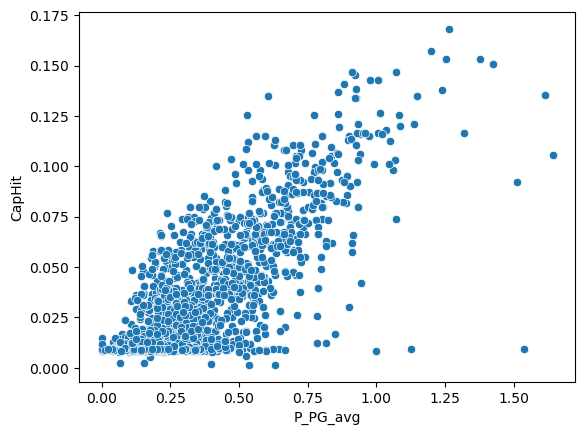

In [175]:
sns.scatterplot(y=dataTable_ng['CapHit'],x=dataTable_ng['P_PG_avg'])

In [154]:
model.resid

2022   -0.014890
2013   -0.023016
2015   -0.001633
2017    0.025635
2021   -0.019036
          ...   
2021    0.002237
2022   -0.036748
2021   -0.057913
2021   -0.014335
2022    0.009116
Length: 1598, dtype: float64

In [169]:
np.sqrt(np.sum((model.resid-dataTable_ng['CapHit'])**2)/len(model.resid))

0.04455978075279575

In [153]:
0.04*81500000

3260000.0

In [98]:
import seaborn as sns

<AxesSubplot: xlabel='GAMES_PLAYED_avg', ylabel='Cap Hit'>

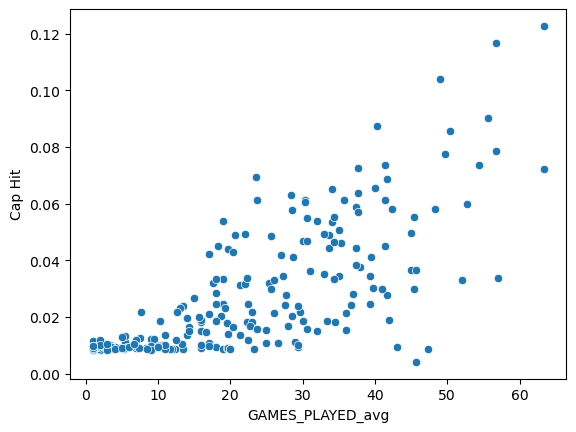

In [1213]:
sns.scatterplot(x=dataTable_g['GAMES_PLAYED_avg'],y=dataTable_g['Cap Hit'])

In [1]:
import statsmodels

In [155]:
from sklearn.linear_model import Ridge

In [156]:
ridge_model = Ridge(alpha=1.0)

In [162]:
y = dataTable_ng['CapHit']
X = dataTable_ng.drop(columns=['Value','Length','AAV','CapHit','Position','Nationality'],axis=1)

In [163]:
ridge_model.fit(X,y)

Ridge()

In [165]:
yhat = ridge_model.predict(X)

In [167]:
np.sqrt(np.sum((yhat-y)**2)/len(yhat))

0.012579691336556467

## specification

Data - players stats, biography, info for each season in a dictionary
Contract data - data for each player in a table

player data structure - find player similarity by average career statistics, and then by trajectory

In [ ]:
## specification

Date 

In [ ]:
https://statsapi.web.nhl.com/api/v1/draft/YEAR